# LSTM Sentiment Classification with NusaX-Sentiment Dataset

This notebook explores different LSTM architectures for Indonesian sentiment classification using the NusaX-Sentiment dataset.

## 1. Setup and Imports

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

sys.path.append('.')
from datasets.data_loader import NusaXDataLoader
from preprocessing.text_preprocessor import IndonesianTextPreprocessor
from models.lstm_keras import LSTMSentimentModel, LSTMConfig

## 2. Data Loading and Preprocessing

In [5]:
def load_and_preprocess_data():
    loader = NusaXDataLoader()
    train_df, valid_df, test_df = loader.load_dataset()
    
    train_texts, train_labels = loader.get_texts_and_labels(train_df)
    val_texts, val_labels = loader.get_texts_and_labels(valid_df)
    test_texts, test_labels = loader.get_texts_and_labels(test_df)
    
    preprocessor = IndonesianTextPreprocessor(max_tokens=10000, max_sequence_length=128)
    preprocessor.build_vectorizer(train_texts)
    
    x_train = preprocessor.preprocess_texts(train_texts)
    x_val = preprocessor.preprocess_texts(val_texts)
    x_test = preprocessor.preprocess_texts(test_texts)
    
    return {
        'x_train': x_train, 'y_train': train_labels,
        'x_val': x_val, 'y_val': val_labels,
        'x_test': x_test, 'y_test': test_labels,
        'vocab_size': preprocessor.get_vocabulary_size()
    }

data = load_and_preprocess_data()

## 3. Hyperparameter Experiment and Analysis

In [6]:
def get_experiments(vocab_size):
    base = {'vocab_size': vocab_size, 'embedding_dim': 128, 'dropout_rate': 0.3, 
            'dense_units': 32, 'num_classes': 3, 'max_sequence_length': 128}
    
    experiments = []
    
    for num_layers in [1, 2, 3]:
        config = LSTMConfig(lstm_units=64, num_lstm_layers=num_layers, bidirectional=False, **base)
        experiments.append((f"lstm_layers_{num_layers}", config))
    
    for lstm_units in [32, 64, 128]:
        config = LSTMConfig(lstm_units=lstm_units, num_lstm_layers=1, bidirectional=False, **base)
        experiments.append((f"lstm_units_{lstm_units}", config))
    
    for bidirectional in [False, True]:
        direction = "bidirectional" if bidirectional else "unidirectional"
        config = LSTMConfig(lstm_units=64, num_lstm_layers=1, bidirectional=bidirectional, **base)
        experiments.append((f"lstm_{direction}", config))
    
    return experiments

experiments = get_experiments(data['vocab_size'])

In [7]:
def train_model(config, experiment_name, data_dict, epochs=15):
    model = LSTMSentimentModel(config)
    model.build_model()
    model.compile_model()
    
    history = model.train(
        data_dict['x_train'], data_dict['y_train'],
        data_dict['x_val'], data_dict['y_val'],
        epochs=epochs, batch_size=32, verbose=0
    )
    
    test_results = model.evaluate(data_dict['x_test'], data_dict['y_test'])
    val_results = model.evaluate(data_dict['x_val'], data_dict['y_val'])
    
    return {
        'history': history,
        'test_results': test_results,
        'val_results': val_results,
        'config': config.to_dict()
    }

In [8]:
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history.history['loss']) + 1)
    ax1.plot(epochs, history.history['loss'], 'b-', linewidth=2)
    ax1.plot(epochs, history.history['val_loss'], 'r-', linewidth=2)
    ax1.set_title(f'{title} - Loss')
    ax1.legend(['Train', 'Val'])
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs, history.history['accuracy'], 'b-', linewidth=2)
    ax2.plot(epochs, history.history['val_accuracy'], 'r-', linewidth=2)
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend(['Train', 'Val'])
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Neutral', 'Positive'],
               yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(title)
    plt.tight_layout()
    plt.show()

Training lstm_layers_1...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


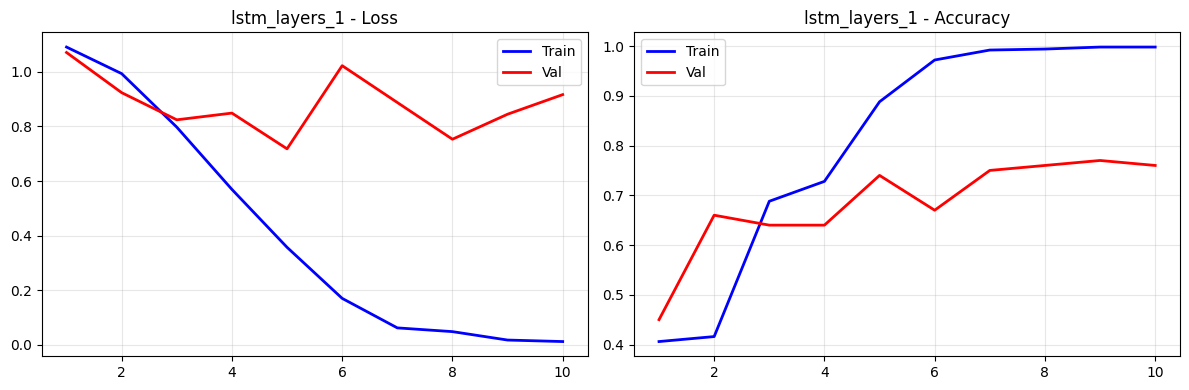

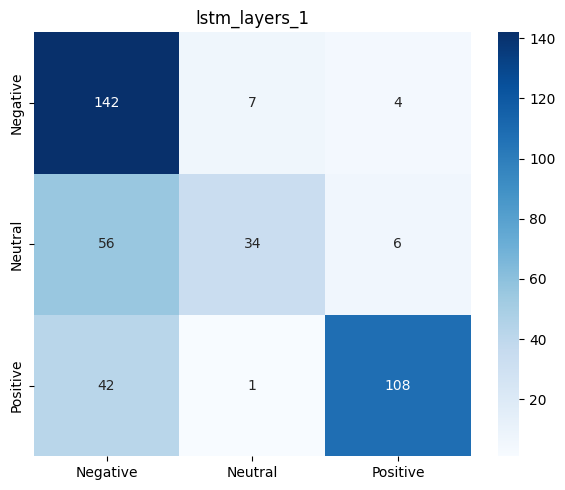

Test F1: 0.6728
Training lstm_layers_2...

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


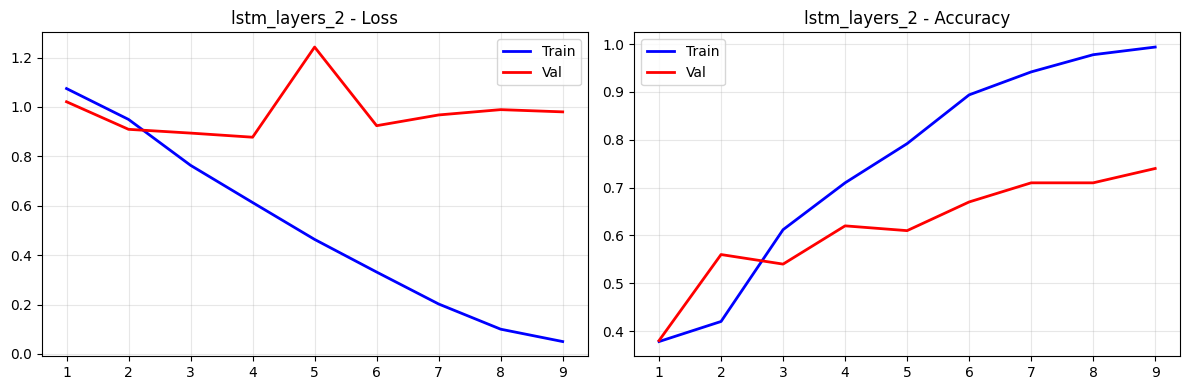

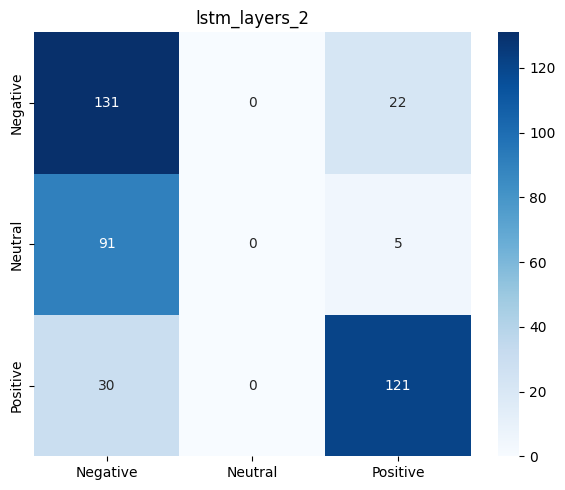

Test F1: 0.4854
Training lstm_layers_3...

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


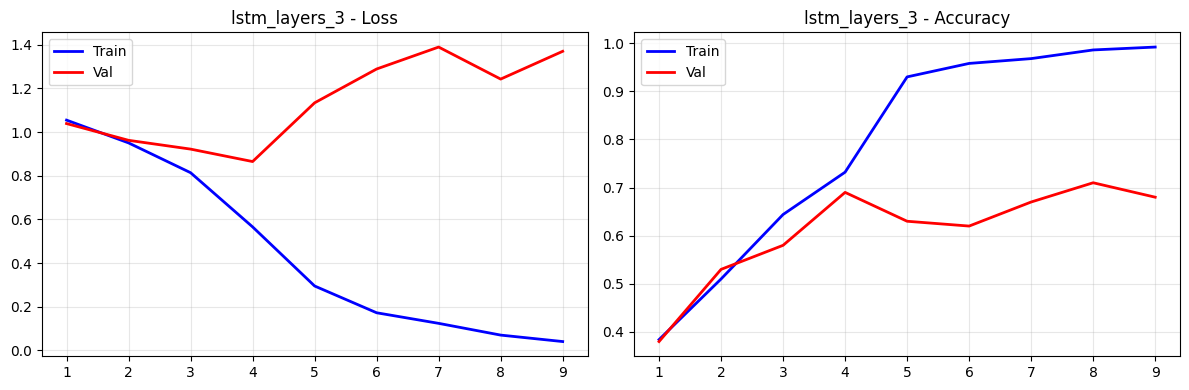

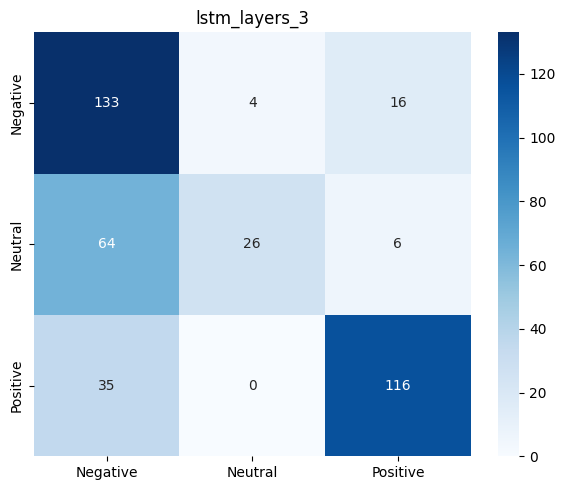

Test F1: 0.6355
Training lstm_units_32...

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.


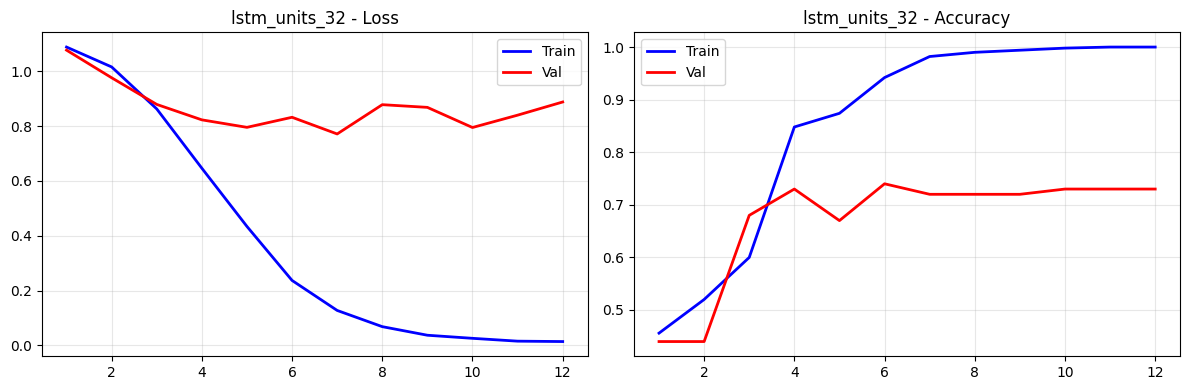

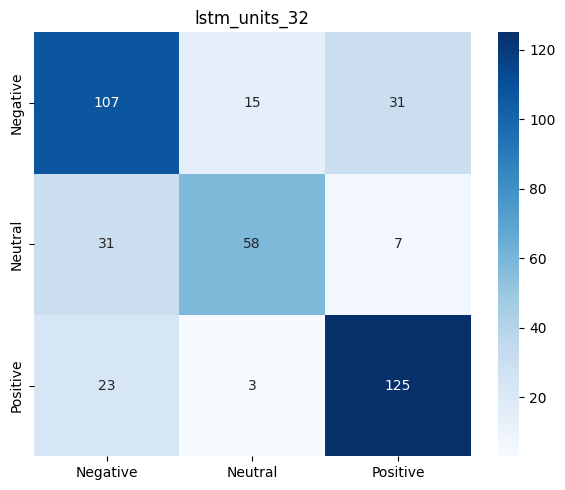

Test F1: 0.7174
Training lstm_units_64...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


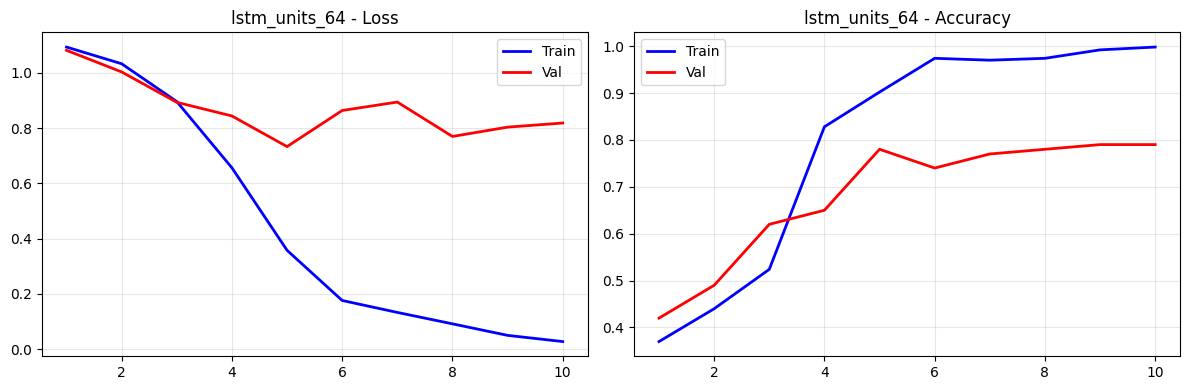

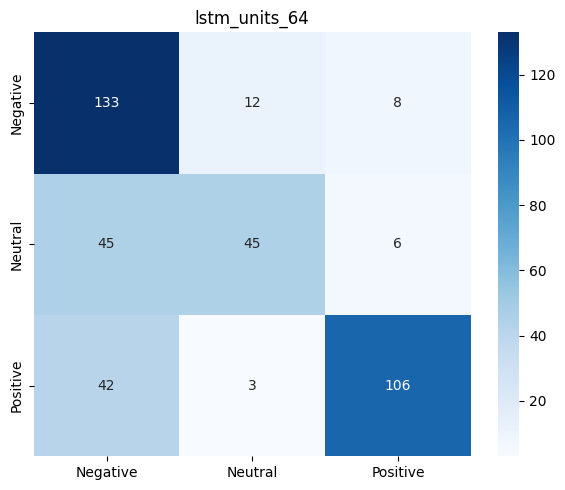

Test F1: 0.6908
Training lstm_units_128...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


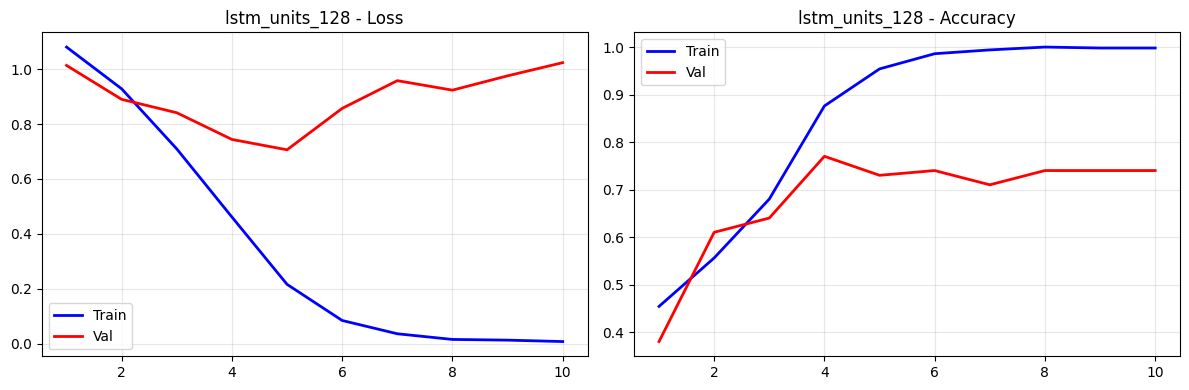

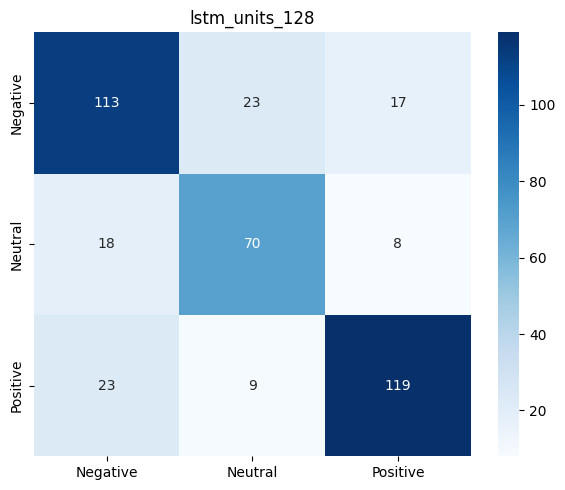

Test F1: 0.7500
Training lstm_unidirectional...

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.


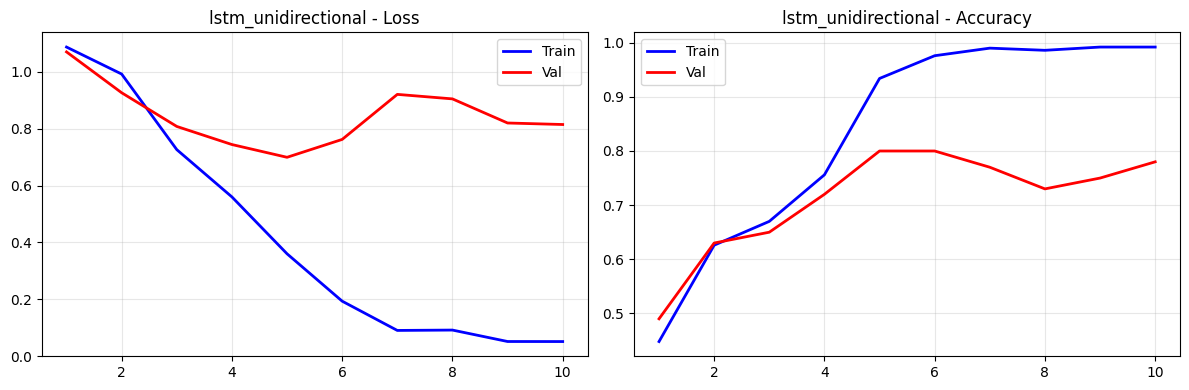

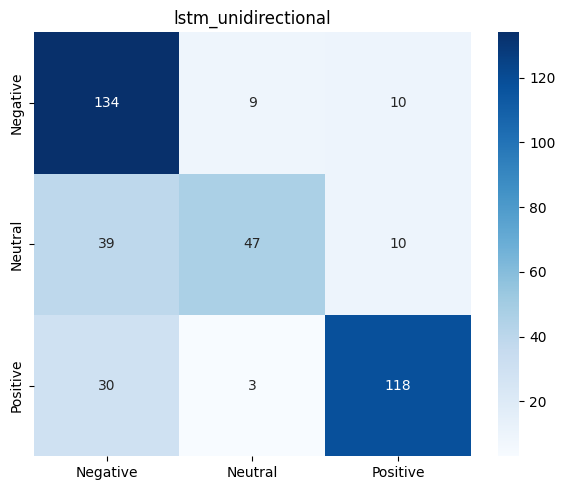

Test F1: 0.7253
Training lstm_bidirectional...

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


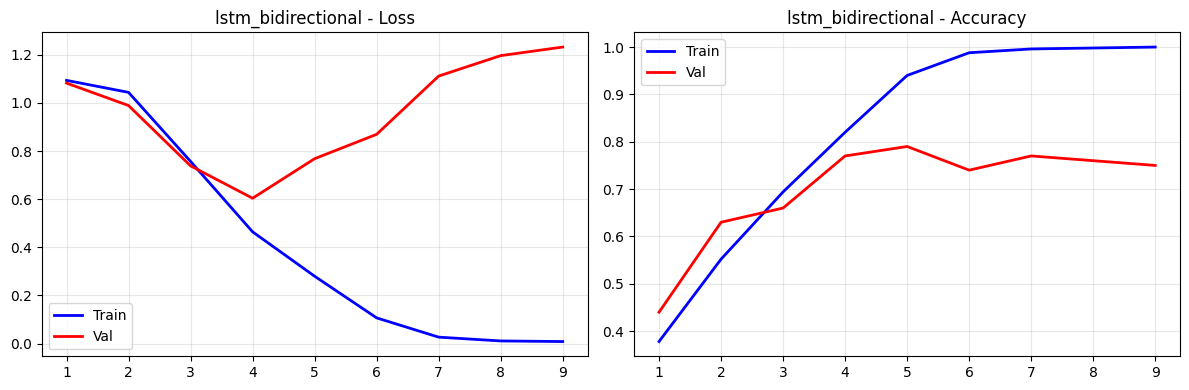

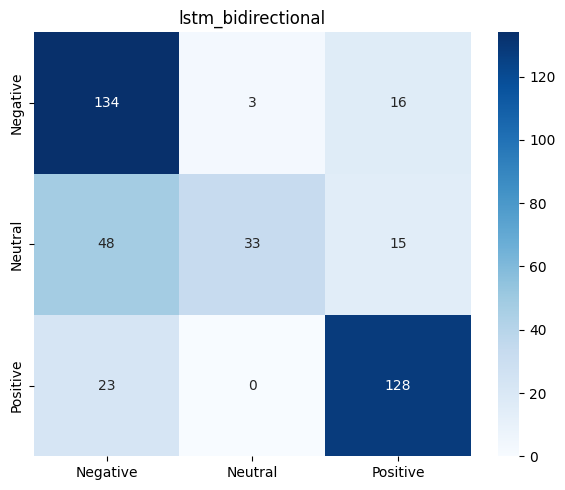

Test F1: 0.6915


In [10]:
all_results = {}

for experiment_name, config in experiments:
    print(f"Training {experiment_name}...")
    
    results = train_model(config, experiment_name, data, epochs=15)
    
    plot_training_history(results['history'], experiment_name)
    plot_confusion_matrix(data['y_test'], results['test_results']['predictions'], experiment_name)
    
    all_results[experiment_name] = {
        'test_macro_f1': results['test_results']['macro_f1'],
        'test_accuracy': results['test_results']['test_accuracy'],
        'val_macro_f1': results['val_results']['macro_f1'],
        'config': results['config']
    }
    
    print(f"Test F1: {results['test_results']['macro_f1']:.4f}")

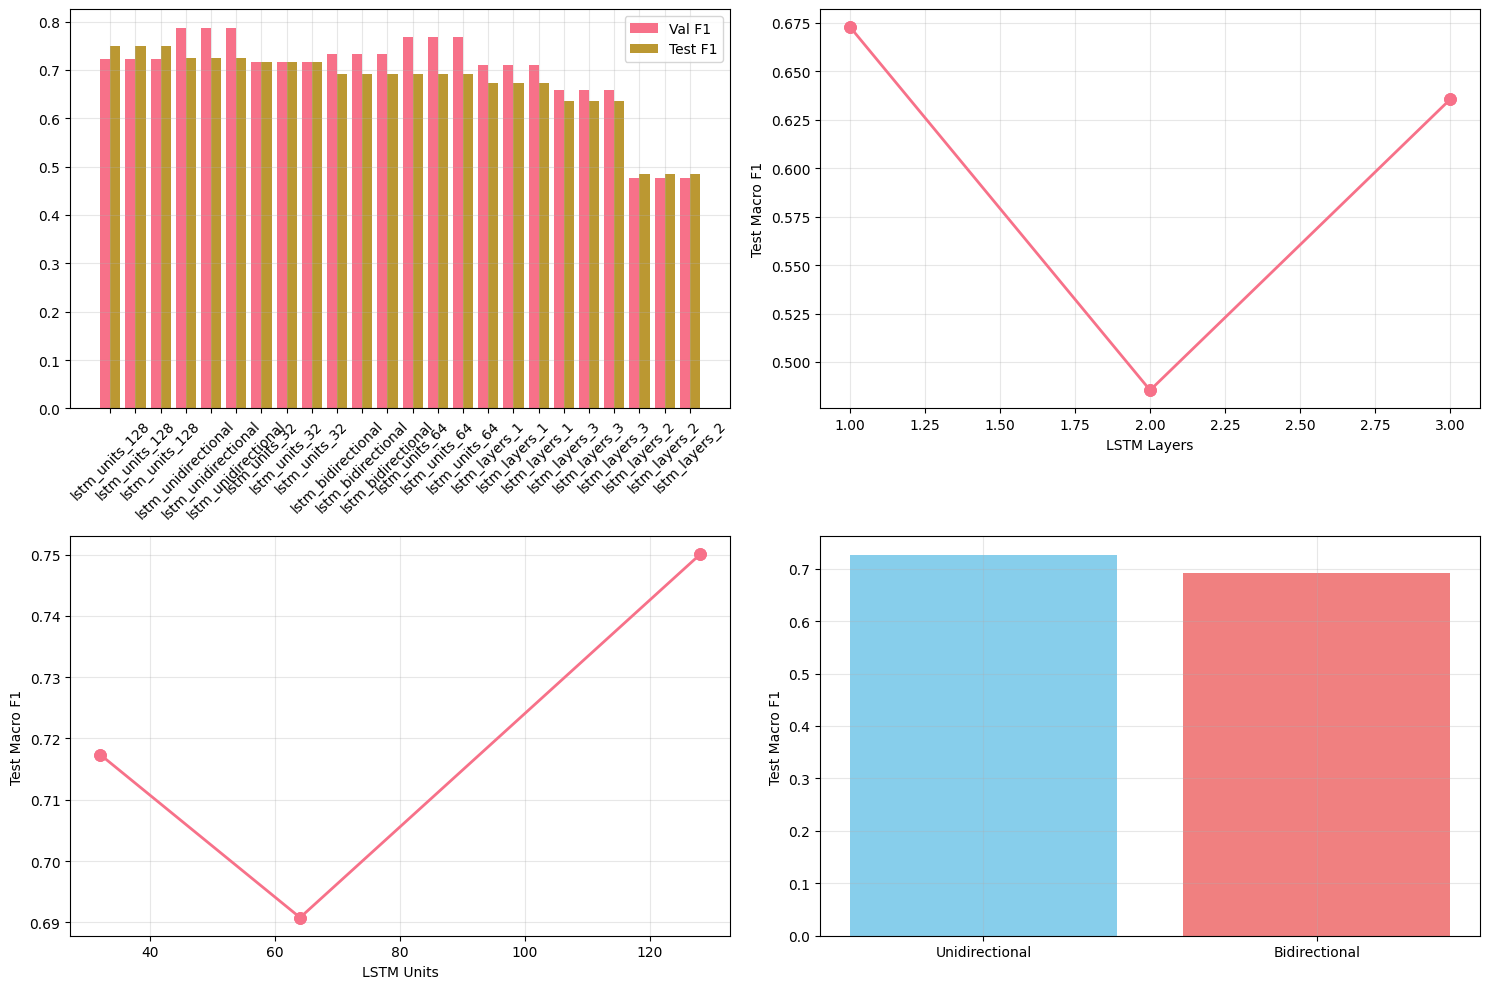

In [13]:
f_data = []
for exp_name, results in all_results.items():
    df_data.append({
        'Experiment': exp_name,
        'LSTM Layers': results['config']['num_lstm_layers'],
        'LSTM Units': results['config']['lstm_units'], 
        'Bidirectional': results['config']['bidirectional'],
        'Test Macro F1': results['test_macro_f1'],
        'Val Macro F1': results['val_macro_f1']
    })

df_results = pd.DataFrame(df_data).sort_values('Test Macro F1', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall comparison
exp_names = df_results['Experiment']
test_f1 = df_results['Test Macro F1'] 
val_f1 = df_results['Val Macro F1']

x = np.arange(len(exp_names))
axes[0,0].bar(x - 0.2, val_f1, 0.4, label='Val F1')
axes[0,0].bar(x + 0.2, test_f1, 0.4, label='Test F1')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(exp_names, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# LSTM layers effect
layer_exp = df_results[df_results['Experiment'].str.contains('layers')].sort_values('LSTM Layers')
axes[0,1].plot(layer_exp['LSTM Layers'], layer_exp['Test Macro F1'], 'o-', linewidth=2, markersize=8)
axes[0,1].set_xlabel('LSTM Layers')
axes[0,1].set_ylabel('Test Macro F1')
axes[0,1].grid(True, alpha=0.3)

# LSTM units effect  
units_exp = df_results[df_results['Experiment'].str.contains('units')].sort_values('LSTM Units')
axes[1,0].plot(units_exp['LSTM Units'], units_exp['Test Macro F1'], 'o-', linewidth=2, markersize=8)
axes[1,0].set_xlabel('LSTM Units')
axes[1,0].set_ylabel('Test Macro F1')
axes[1,0].grid(True, alpha=0.3)

# Bidirectional comparison
bi_exp = df_results[df_results['Experiment'].str.contains('directional')]
directions = ['Unidirectional', 'Bidirectional']
uni_f1 = bi_exp[bi_exp['Bidirectional'] == False]['Test Macro F1'].iloc[0]
bi_f1 = bi_exp[bi_exp['Bidirectional'] == True]['Test Macro F1'].iloc[0]
axes[1,1].bar(directions, [uni_f1, bi_f1], color=['skyblue', 'lightcoral'])
axes[1,1].set_ylabel('Test Macro F1')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()